
Melhor solução segundo PROMETHEE I:
f1                    514.000000
f2                   1252.300650
Fluxo_Promethee_I       0.036395
Name: 5, dtype: float64

Melhor solução segundo ELECTRE I:
f1                  352.000000
f2                 1378.512141
Fluxo_Electre_I       7.000000
Name: 3, dtype: float64


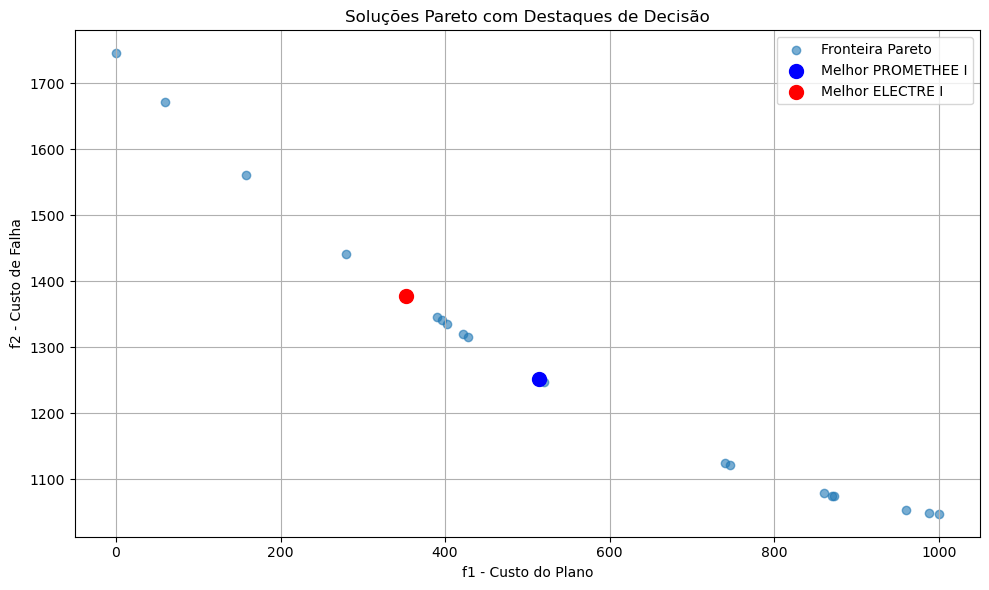

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# carrega os resultados da fronteira de Pareto (csv gerado pela etapa de otimização)
df_raw = pd.read_csv("resultados_pareto_somaPonderada_2025-06-01_02-07-02.csv")

# remove duplicatas estritas e obtém conjunto não-dominado
# (supõe-se que df_raw já contém a fronteira)
df_nd = df_raw.drop_duplicates(subset=["f1","f2"]).reset_index(drop=True)

# normaliza f1 e f2 usando todo o conjunto não-dominado
denom_f1 = df_nd['f1'].max() - df_nd['f1'].min()
denom_f2 = df_nd['f2'].max() - df_nd['f2'].min()
if denom_f1 == 0 or denom_f2 == 0:
    raise ValueError("Não há variação em f1 ou f2 para normalizar")
df_nd['f1_norm'] = (df_nd['f1'] - df_nd['f1'].min()) / denom_f1
df_nd['f2_norm'] = (df_nd['f2'] - df_nd['f2'].min()) / denom_f2

# limita a 20 soluções após normalização
if len(df_nd) > 20:
    df = df_nd.sample(n=20, random_state=203).reset_index(drop=True)
else:
    df = df_nd.copy()

# matriz de decisão normalizada: [f1_norm, f2_norm]
matriz_decisao = df[['f1_norm','f2_norm']].values

# pesos iguais para f1 e f2
pesos = np.array([0.5, 0.5])

# PROMETHEE I: calcula fluxo de saída (phi+) e entrada (phi-)
def promethee_i(matriz, pesos):
    n = matriz.shape[0]
    matriz_pref = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            diferenca = np.maximum(0, matriz[j] - matriz[i])
            matriz_pref[i, j] = np.dot(pesos, diferenca)
    fluxo_saida = np.mean(matriz_pref, axis=1)
    fluxo_entrada = np.mean(matriz_pref, axis=0)
    return fluxo_saida, fluxo_entrada

# ELECTRE I: concordância e discordância simples
def electre_i(matriz, pesos, c_thresh=0.5, d_thresh=0.5):
    n, m = matriz.shape
    mat_conc = np.zeros((n, n))
    mat_disc = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            conc = 0.0
            disc = 0.0
            for k in range(m):
                if matriz[i, k] <= matriz[j, k]:
                    conc += pesos[k]
                else:
                    disc = max(disc, abs(matriz[i, k] - matriz[j, k]))
            mat_conc[i, j] = conc
            mat_disc[i, j] = disc
    # sobreposição: outranking
    outranking = (mat_conc >= c_thresh) & (mat_disc <= d_thresh)
    fluxo_saida = np.sum(outranking, axis=1)
    fluxo_entrada = np.sum(outranking, axis=0)
    return fluxo_saida, fluxo_entrada

# calcula fluxos para os 20 selecionados
prom_saida, prom_entrada = promethee_i(matriz_decisao, pesos)
elec_saida, elec_entrada = electre_i(matriz_decisao, pesos)

df['Fluxo_Promethee_I'] = prom_saida - prom_entrada
df['Fluxo_Electre_I'] = elec_saida - elec_entrada

# seleciona melhores soluções
best_prom = df['Fluxo_Promethee_I'].idxmax()
best_elec = df['Fluxo_Electre_I'].idxmax()

print("\nMelhor solução segundo PROMETHEE I:")
print(df.loc[best_prom, ['f1','f2','Fluxo_Promethee_I']])

print("\nMelhor solução segundo ELECTRE I:")
print(df.loc[best_elec, ['f1','f2','Fluxo_Electre_I']])

# plota fronteira e destaca escolhas
plt.figure(figsize=(10, 6))
plt.scatter(df['f1'], df['f2'], label="Fronteira Pareto", alpha=0.6)
plt.scatter(df.loc[best_prom,'f1'], df.loc[best_prom,'f2'], color='blue', label="Melhor PROMETHEE I", s=100)
plt.scatter(df.loc[best_elec,'f1'], df.loc[best_elec,'f2'], color='red', label="Melhor ELECTRE I", s=100)
plt.xlabel("f1 - Custo do Plano")
plt.ylabel("f2 - Custo de Falha")
plt.title("Soluções Pareto com Destaques de Decisão")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
